In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from setup_env import setup_environment

setup_environment()

In [3]:
import numpy as np
import pennylane as qml
import pennylane.numpy as pnp
from src.hsip import HSIP
from src.superop import superoperator
from src.utils import QubitChannel

### QNode Superoperator

In [4]:
def circuit_1(params):
    
    # init state
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.Hadamard(2)

    # circuit
    qml.Hadamard(0)

    # S and T defined with Phase gate for easy conjugate
    qml.PhaseShift(np.pi / 4, 1)  # T gate
    qml.PhaseShift(np.pi / 2, 2)  # S gate

    qml.PhaseFlip(0.1, wires=0)
    qml.RX(params[0], wires=0)

    qml.DepolarizingChannel(0.1, wires=1)
    qml.DepolarizingChannel(0.1, wires=2)
    
    qml.CRX(params[1], [2, 1])
    
    # ccry
    qml.ctrl(qml.RY, (0, 1))(params[2], wires=2)

    qml.AmplitudeDamping(0.05, wires=0)
    qml.PhaseFlip(0.05, wires=1)
    qml.PhaseFlip(0.05, wires=2)

n_qubits = 3
dev_super_1 = qml.device("default.qubit", wires=2 * n_qubits)
params_1 = pnp.array([0.5, 0.7, 0.3], requires_grad=True)

In [5]:
from pennylane.devices.qubit import create_initial_state, apply_operation

def circuit_2(params):
    qml.CRX(params[0], [1, 0])
    qml.DepolarizingChannel(0.1, wires=1)
    qml.PhaseFlip(0.2, wires=0)
    qml.IsingXX(params[1], [1, 0])
    qml.Hadamard(1)
    qml.PhaseShift(np.pi / 2, 0)
    qml.AmplitudeDamping(0.3, wires=1)
    qml.PhaseFlip(0.4, wires=0)
    qml.IsingYY(params[2], [1, 0])
    qml.CRZ(params[3], [0, 1])
    qml.IsingZZ(params[0], [1, 0])

n_qubits = 2
dev_super_2 = qml.device("default.qubit", wires=2 * n_qubits)
params_2 = pnp.array([0.1, 0.2, 0.3, 0.4], requires_grad=True)

# initial mixed state
psi = create_initial_state(range(n_qubits))
plus_state = apply_operation(qml.Hadamard(0) @ qml.Hadamard(1), psi)
rho = qml.math.dm_from_state_vector(psi.flatten())
rho_plus = qml.math.dm_from_state_vector(plus_state.flatten())

initial_rho = 0.3 * rho + 0.7 * rho_plus
initial_rho

array([[0.475+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j],
       [0.175+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j],
       [0.175+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j],
       [0.175+0.j, 0.175+0.j, 0.175+0.j, 0.175+0.j]])

In [6]:
from sympy import symbols, sqrt, Matrix

d = symbols("d")
alpha = 1 / sqrt(10)
beta = sqrt(1 - d)
gamma = sqrt(d)

K0 = Matrix([[3 * alpha, 0], [0, 3 * beta * alpha]])
K1 = 3 * gamma * alpha * Matrix([[0, 1], [0, 0]])
K2 = Matrix([[beta * alpha, 0], [0, alpha]])
K3 = gamma * alpha * Matrix([[0, 0], [1, 0]])

def circuit_3(params):
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.U3(params[0], params[1], params[2], 1)
    qml.DepolarizingChannel(params[1], 1)
    qml.CRY(params[0], [1, 0])
    QubitChannel(params[3], d, [K0, K1, K2, K3], 0)

n_qubits = 2
dev_super_3 = qml.device("default.qubit", wires=2 * n_qubits)
params_3 = pnp.array([0.1, 0.2, 0.3, 0.4], requires_grad=True)

(<Figure size 1400x700 with 1 Axes>, <Axes: >)


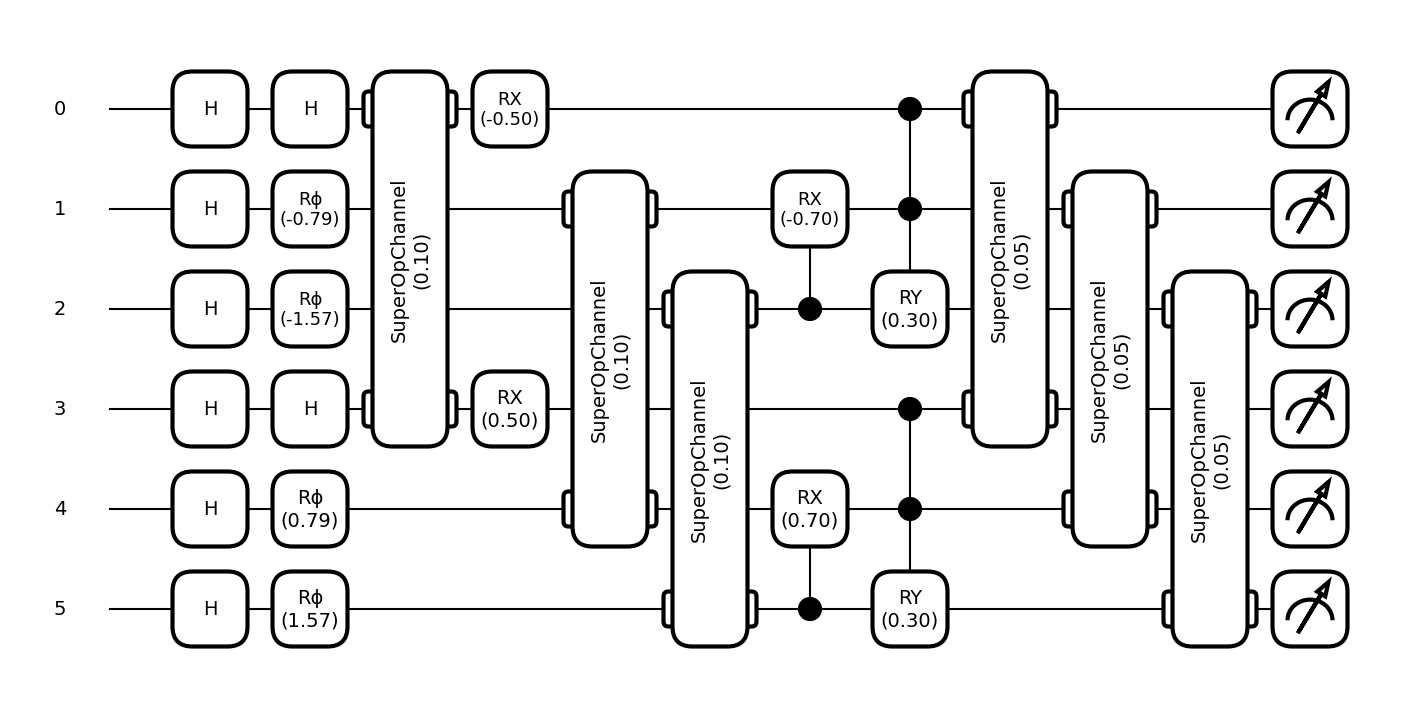

In [7]:
# with custom initial state, we need to use parameter-shift
# something with jacobian doesnt work otherwise
@qml.qnode(dev_super_1, diff_method='parameter-shift')
@superoperator()
def qnode_superop(params):
    circuit_1(params)
    return qml.state()

print(qml.draw_mpl(qnode_superop, decimals=2)(params_1))

## Hilbert Schmidt Metric Tensor

In [8]:
np.set_printoptions(suppress=True)

In [9]:
from src.hsmt import hsmt

mt_fn = hsmt(qnode_superop)
metric_tensor = mt_fn(params_1)

In [10]:
print(np.around(metric_tensor, 9))

[[ 0.30494013-0.j          0.00002033-0.j         -0.00011782-0.j        ]
 [ 0.00002033-0.j          0.10272189-0.00007835j  0.00062103+0.j        ]
 [-0.00011782-0.j          0.00062103+0.j          0.00671961+0.j        ]]
